<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE5-WEEK3/m05w03_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 02

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
#  đặt giá trị ngẫu nhiên cho hệ thống
# với các lần lặp là cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [3]:
# chuyển dữ liệu sang bên GPU để thuận tiện cho việc tính toán dữ liệu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True).item()
x,y = data['X'], data['labels']

In [5]:
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (300, 2)
Shape of y: (300,)


In [6]:
# chia dữ liệu ra thành 3 phần cho quá trình test và quá trình kiểm tra
val_size = 0.2
test_size = 0.125
is_shuffle = True

x_train, x_val, y_train, y_val = train_test_split(
    x, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle)

x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle)

In [7]:
normalizer = StandardScaler()
x_train = normalizer.fit_transform(x_train)
x_val = normalizer.transform(x_val)
x_test = normalizer.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [8]:
# xây dựng lớp dataloader
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [9]:
# tạo batchsize cho data
# hàm Dataloader này có mục đích
batch_size = 32
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

# dataloader dùng để lấy môt batch dữ liệu cùng một lúc, thuận tiện cho việc train
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# xây dựng một mạng multi layer perceptrons
class MLP(nn.Module): # kế thừa từ lớp Module
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.linear1 = nn.Linear(input_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()


  def forward(self, x):
    x = self.linear1(x)
    x = self.tanh(x)
    out = self.output(x)
    return out.squeeze(1)

In [11]:
# xác định chiều đầu vào và đầu ra của kiến trúc
input_dims = x_train.shape[1]
hidden_dims = 128
output_dims = torch.unique(y_train).shape[0]
#output = 1 là do đây không phải là mô hình phân loại mà là mô hình liên tục

In [12]:
model = MLP(input_dims, hidden_dims, output_dims).to(device)

# khai báo hàm loss và opimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
#

In [13]:
def compute_accuracy(y_true, y_pred):
  y_true = torch.cat(y_true)  # Nối tất cả Tensor trong y_true
  y_pred = torch.cat(y_pred)
  _, predicted = torch.max(y_pred, dim = 1)
  correct = (predicted == y_true).sum().item()
  total = len(y_true)
  accuracy = correct / total
  return accuracy

In [14]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []
for epoch in range(epochs):
  train_loss = 0.0
  train_target = []
  train_pred = []
  val_target = []
  val_pred = []

  # phần dùng để train
  model.train()
  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device) # chuyển sang GPU
    y_batch = y_batch.to(device).long() # chuyển sang GPU
    optimizer.zero_grad()
    outputs = model(x_batch)
    loss = criterion(outputs, y_batch)
    # y_batch.unsqueeze(1) dùng để điều chỉnh shape của y khi tính loss
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    # mục đích để tách ra output ra khỏi với gradient và chuyển về CPU để tiện việc tính toán
    train_pred.append(outputs.detach().cpu())
    train_target.append(y_batch.cpu())

  train_loss = train_loss / len(train_dataloader)
  train_losses.append(train_loss)
  train_accs.append(compute_accuracy(y_true=train_target, y_pred=train_pred))

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
      x_batch = x_batch.to(device) # chuyển sang GPU
      y_batch = y_batch.to(device).long() # chuyển sang GPU
      outputs = model(x_batch)
      loss = criterion(outputs, y_batch)
      val_loss += loss.item()
      # mục đích để tách ra output ra khỏi với gradient và chuyển về CPU để tiện việc tính toán
      val_pred.append(outputs.detach().cpu())
      val_target.append(y_batch.cpu())

    val_loss = val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    val_accs.append(compute_accuracy(y_true=val_target, y_pred=val_pred))
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100, Train Loss: 0.8872, Val Loss: 0.8738
Epoch 2/100, Train Loss: 0.7407, Val Loss: 0.8563
Epoch 3/100, Train Loss: 0.7327, Val Loss: 0.8600
Epoch 4/100, Train Loss: 0.7268, Val Loss: 0.8638
Epoch 5/100, Train Loss: 0.7226, Val Loss: 0.8780
Epoch 6/100, Train Loss: 0.7143, Val Loss: 0.8612
Epoch 7/100, Train Loss: 0.7198, Val Loss: 0.8436
Epoch 8/100, Train Loss: 0.7025, Val Loss: 0.8347
Epoch 9/100, Train Loss: 0.7179, Val Loss: 0.8292
Epoch 10/100, Train Loss: 0.7195, Val Loss: 0.8148
Epoch 11/100, Train Loss: 0.6924, Val Loss: 0.8408
Epoch 12/100, Train Loss: 0.7275, Val Loss: 0.8287
Epoch 13/100, Train Loss: 0.6920, Val Loss: 0.8127
Epoch 14/100, Train Loss: 0.6764, Val Loss: 0.8003
Epoch 15/100, Train Loss: 0.6604, Val Loss: 0.8163
Epoch 16/100, Train Loss: 0.6878, Val Loss: 0.7984
Epoch 17/100, Train Loss: 0.6702, Val Loss: 0.7855
Epoch 18/100, Train Loss: 0.6651, Val Loss: 0.7904
Epoch 19/100, Train Loss: 0.6704, Val Loss: 0.7745
Epoch 20/100, Train Loss: 0.6595, Val Lo

Text(0.5, 1.0, 'Validation acc')

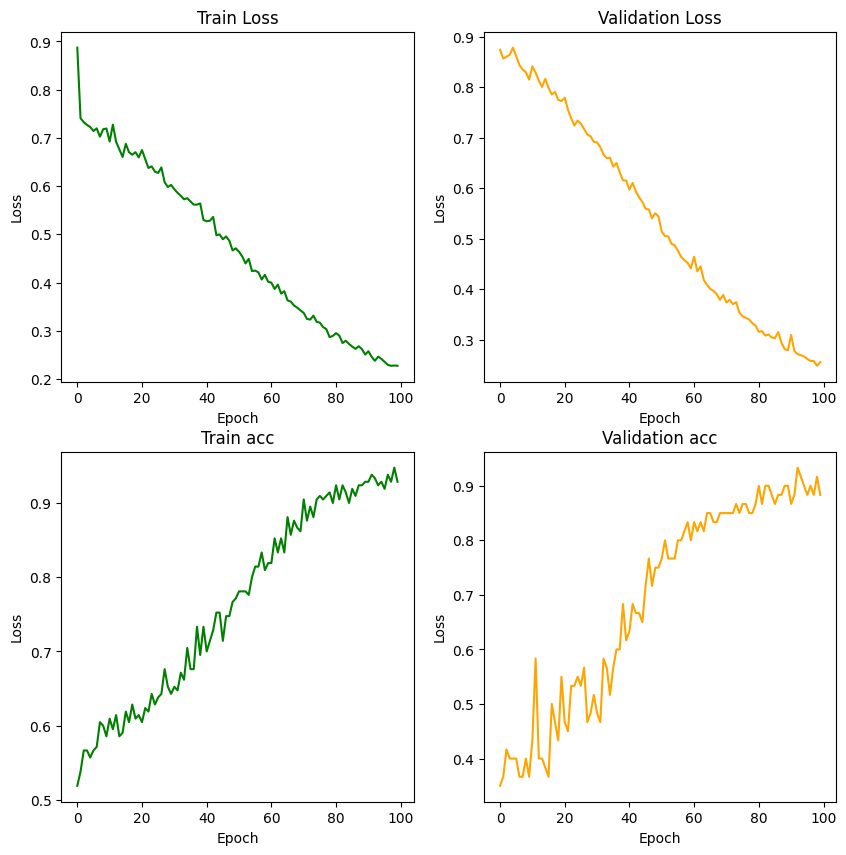

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(train_losses, color = 'green')
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('Train Loss')

ax[0,1].plot(val_losses, color = 'orange')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_title('Validation Loss')

ax[1,0].plot(train_accs, color = 'green')
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Loss')
ax[1,0].set_title('Train acc')

ax[1,1].plot(val_accs, color = 'orange')
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_title('Validation acc')

In [16]:
test_target = []
test_pred = []
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dataloader:
    x_batch = x_batch.to(device) # chuyển sang GPU
    y_batch = y_batch.to(device) # chuyển sang GPU
    outputs = model(x_batch)

    # mục đích để tách ra output ra khỏi với gradient và chuyển về CPU để tiện việc tính toán
    test_pred.append(outputs.cpu())
    test_target.append(y_batch.cpu())

  test_acc = compute_accuracy(y_true=test_target, y_pred=test_pred)
  print(f'Test acc: {test_acc}')

Test acc: 0.9
